In [1]:
import os
import optuna
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
load_dotenv()

/home/codespace/.cache/pypoetry/virtualenvs/stock-volatility-prediction-MrqSbHyr-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Global Variables
api_key = os.getenv('FMP_API_KEY')
ticker = 'NVDA'
start_date = '2018-01-01'
end_date = '2024-01-01'

In [3]:
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={start_date}&to={end_date}&apikey={api_key}"
response = requests.get(url).json()

In [88]:
data = pd.DataFrame(response["historical"])
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)
data["return"] = data["close"].pct_change()
data.dropna(inplace=True)
data["return_squared"] = data["return"] ** 2
data["realized_vol"] = data["return"].rolling(window=5).std()
# data.reset_index(drop=True, inplace=True)
# data = data.iloc[1:].reset_index(drop=True)

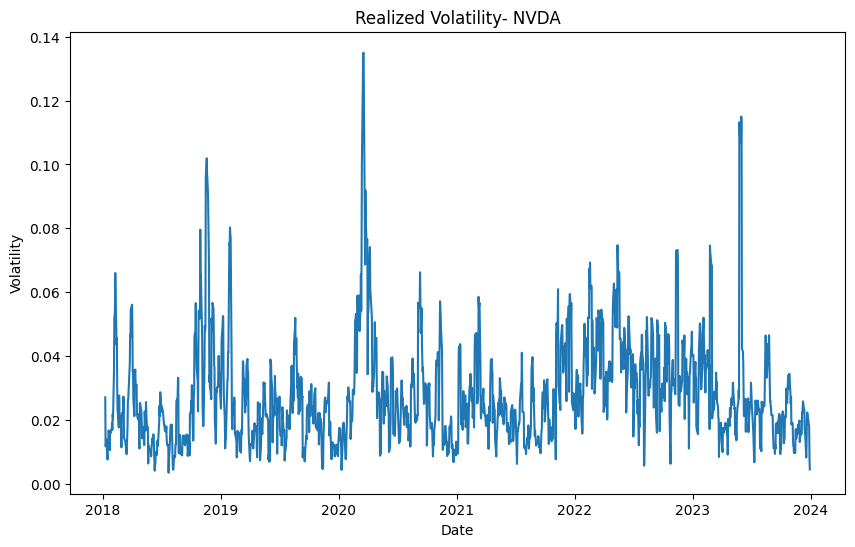

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(data["date"], data["realized_vol"])
plt.title('Realized Volatility- NVDA')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [97]:
df = (
    data[["return_squared", "realized_vol"]].copy()
    .dropna()
    .assign(
        response=lambda x: x["realized_vol"].shift(-1),
    )
    # .dropna()
    .reset_index(drop=True)
)

In [103]:
df.dropna(inplace=True)

In [99]:
n = int(len(df) * 0.8)
print(n)
svr_rbf = SVR(kernel='rbf')

1203


In [105]:
X = df[["return_squared", "realized_vol"]]
y = df["response"]

In [106]:
def objective(trial):
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e2)
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    epsilon = trial.suggest_loguniform('epsilon', 1e-5, 1e2)
    
    svr_rbf = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)
    # svr_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
    svr_rbf.fit(X.iloc[:n], y.iloc[:n])
    predictions = svr_rbf.predict(X.iloc[n:])
    mse = mean_squared_error(y.iloc[n:], predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-04-25 02:30:07,500] A new study created in memory with name: no-name-51724602-00fb-42c1-82ff-d7f184a7f1e4
[I 2024-04-25 02:30:07,506] Trial 0 finished with value: 0.0009136141617929053 and parameters: {'gamma': 0.0015773457973961356, 'C': 51.085413119533214, 'epsilon': 0.04805309469007037}. Best is trial 0 with value: 0.0009136141617929053.
[I 2024-04-25 02:30:07,511] Trial 1 finished with value: 0.0019748251515364175 and parameters: {'gamma': 0.0015169386128735065, 'C': 0.0008495850504457184, 'epsilon': 0.8678455085690284}. Best is trial 0 with value: 0.0009136141617929053.
[I 2024-04-25 02:30:07,515] Trial 2 finished with value: 0.001974825151536422 and parameters: {'gamma': 7.365976079983537, 'C': 33.58681210896176, 'epsilon': 2.267066764309718}. Best is trial 0 with value: 0.0009136141617929053.
[I 2024-04-25 02:30:07,519] Trial 3 finished with value: 0.001974825151536422 and parameters: {'gamma': 10.39979553563445, 'C': 0.027925845402914748, 'epsilon': 1.6928614921094605}.

In [113]:
svr_rbf = SVR(kernel='rbf', **best_params)
svr_rbf.fit(X.iloc[:n], y.iloc[:n])
predictions = pd.DataFrame(svr_rbf.predict(X.iloc[n:]))
mean_squared_error(y.iloc[n:], predictions)

9.191040239458629e-05

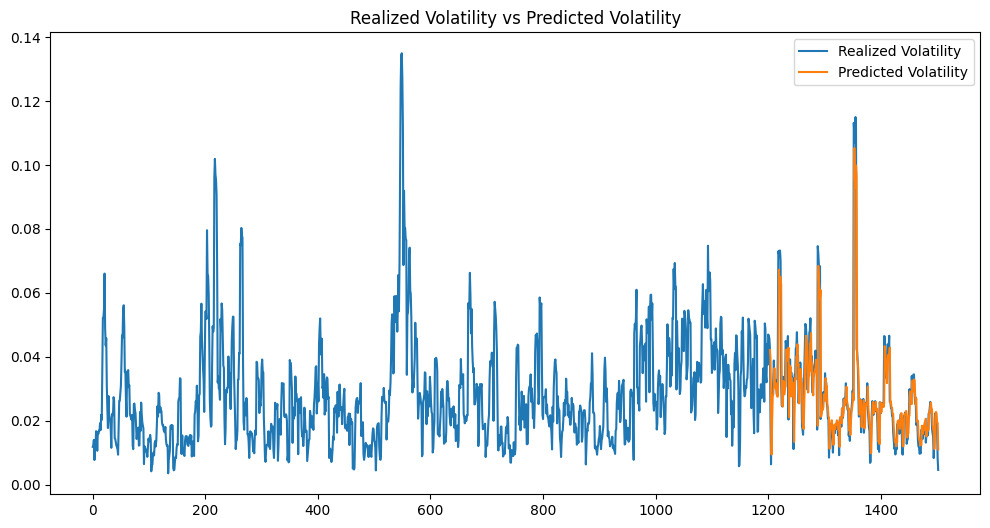

In [114]:
predictions.index = y.index[n:]
plt.figure(figsize=(12, 6))
plt.plot(y, label='Realized Volatility')
plt.plot(predictions, label='Predicted Volatility')
plt.title('Realized Volatility vs Predicted Volatility')
plt.legend()
plt.show()